**Análisis de modelos**

**Preparación de datos**

Importamos los datos, preparamos el dataset y creamos los conjuntos de entrenamiento.

Creamos conjuntos de entrenamiento con diferentes algoritmos de oversampling

In [7]:
import xgboost
from sklearn.model_selection import train_test_split
from src.data_utils.data_utils import read_data, prepare_dummy_cols, normalize_num_vars

excel_file_path = "D:\\develop\\predict_lapse\\data\\BBDD_Impago_1.0.xlsx"

df = read_data(excel_file_path)

cat_vars = ['Canal', 'Domiciliacion', 'Figuras', 'Motor', 'Pago', 'SegundoConductor', 'Tipo_Furgoneta', 'Tipo_Moto', 'Tipo_Turismo',  'Zonas_Zona1', 'Zonas_Zona2', 'Zonas_Zona3', 'Zonas_Zona4', 'Zonas_Zona5', 'Zonas_Zona6', 'Zonas_Zona7', 'Zonas_Zona8']

feature_cols = ['Pago', 'Domiciliacion', 'Anyomatricula', 'Prima', 'Valor',
                'ValorVehículo', 'Motor_2', 'Motor_3', 'Canal', 'Socioec', 'Antigüedad', 'Carnet', 'SegundoConductor', 'Figuras', 'Tipo_Moto', 'Tipo_Turismo', 'Zonas_Zona2', 'Zonas_Zona3', 'Zonas_Zona4', 'Zonas_Zona5', 'Zonas_Zona6', 'Zonas_Zona7', 'Zonas_Zona8']

df_dummy = prepare_dummy_cols(df, ['Tipo', 'Zonas', 'Motor'] )

num_vars = ['Anyomatricula', 'Valor', 'Prima', 'ValorVehículo', 'Socioec','Antigüedad', 'Carnet']

X = df_dummy[feature_cols]
y = df['Impago']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = normalize_num_vars(X_train, num_vars)
X_test = normalize_num_vars(X_test, num_vars)


Por último, ejecutamos los modelos con los mejores parámetros conseguidos.

In [8]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(
            n_estimators=600, random_state=42,
            n_jobs=-1,
            max_depth=18,
            min_samples_leaf=3,
            min_samples_split=2,
            max_features=0.3,
            bootstrap=True,
            max_samples=0.7,
            ccp_alpha=1e-05
        )

rf.fit(X_train, y_train)




,n_estimators,600
,criterion,'gini'
,max_depth,18
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,0.3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Utilizamos SHAP para explicar el modelo

In [9]:
import shap
import numpy as np
import pandas as pd

X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42
    )

X_tr_num   = X_tr.astype("float32")
X_test_num = X_test.astype("float32")

explainer = shap.Explainer(rf, X_tr_num)
sv = explainer(X_test_num)


100%|===================| 11689/11690 [10:49<00:00]        

Realizamos los gráficos globales

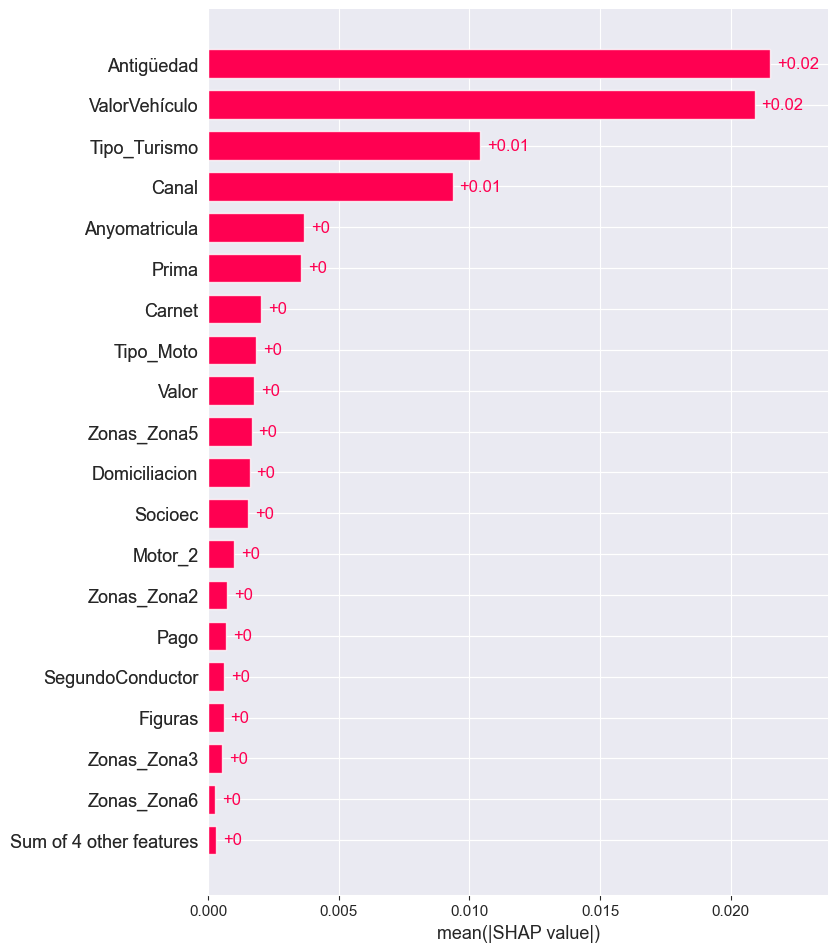

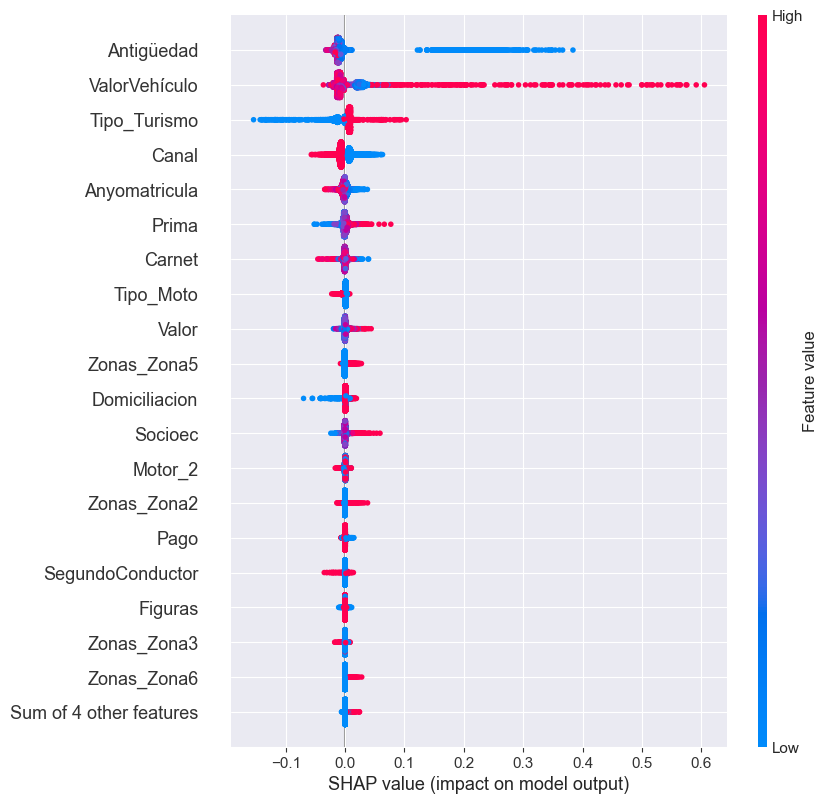

In [14]:
sv_pos = sv[..., 1]

shap.plots.bar(sv_pos, max_display=20)
shap.plots.beeswarm(sv_pos, max_display=20)


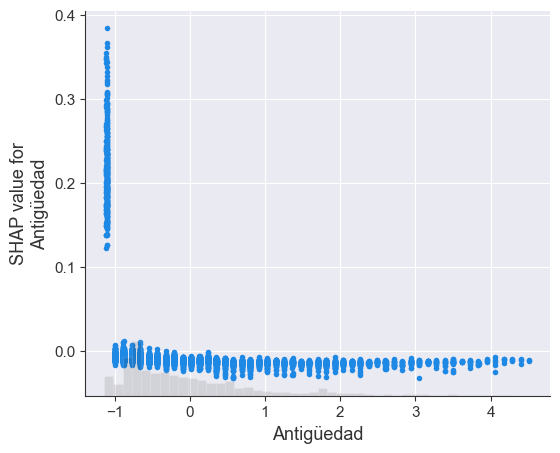

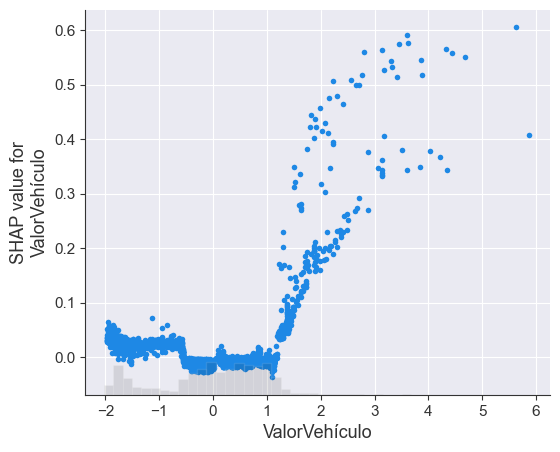

In [15]:
shap.plots.scatter(sv_pos[:, "Antigüedad"])
shap.plots.scatter(sv_pos[:, "ValorVehículo"])

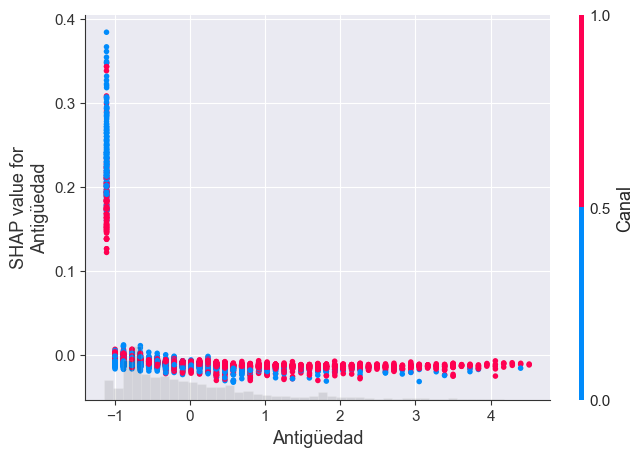

In [20]:
shap.plots.scatter(sv_pos[:, "Antigüedad"], color=sv_pos[:, "Canal"])


In [17]:
S = pd.DataFrame(sv_pos.values, columns=X_test_num.columns)
tmp = X_test_num.copy()
tmp["shap_canal"] = S["Canal"]

tmp.groupby("Canal")["shap_canal"].agg(["mean","median","count"])

,mean,median,count
Canal,,,
0.0,-0.001501,-0.006046,524
1.0,-0.001794,-0.006169,638


Identificamos FP y FN

[Random_Forest] Accuracy train: 0.9757 | test: 0.9595
[Random_Forest] Balanced Acc train: 0.9317 | test: 0.7818
[Random_Forest] Precision(1): 0.3792 | Recall(1): 0.5930 | F1(1): 0.4626
[Random_Forest] Confusion matrix (test):
[[5506  167]
 [  70  102]]


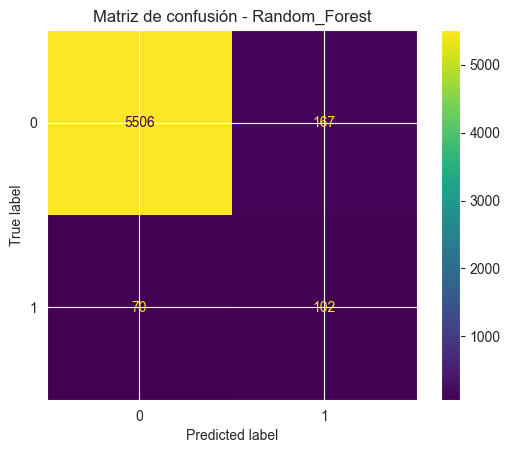

AUC-ROC (train): 0.9935
AUC-ROC (test) : 0.8893
PR-AUC  (train): 0.8462
PR-AUC  (test) : 0.5496


In [25]:
from src.model_utils.mod_evaluation import run_model_and_evaluate

rf_metrics, aucs, fp, fn, ex = run_model_and_evaluate(
                X_train, y_train,
                X_test, y_test,
                'Random_Forest', rf
)


Realizamos los gráficos para falsos positivos y falsos negativos

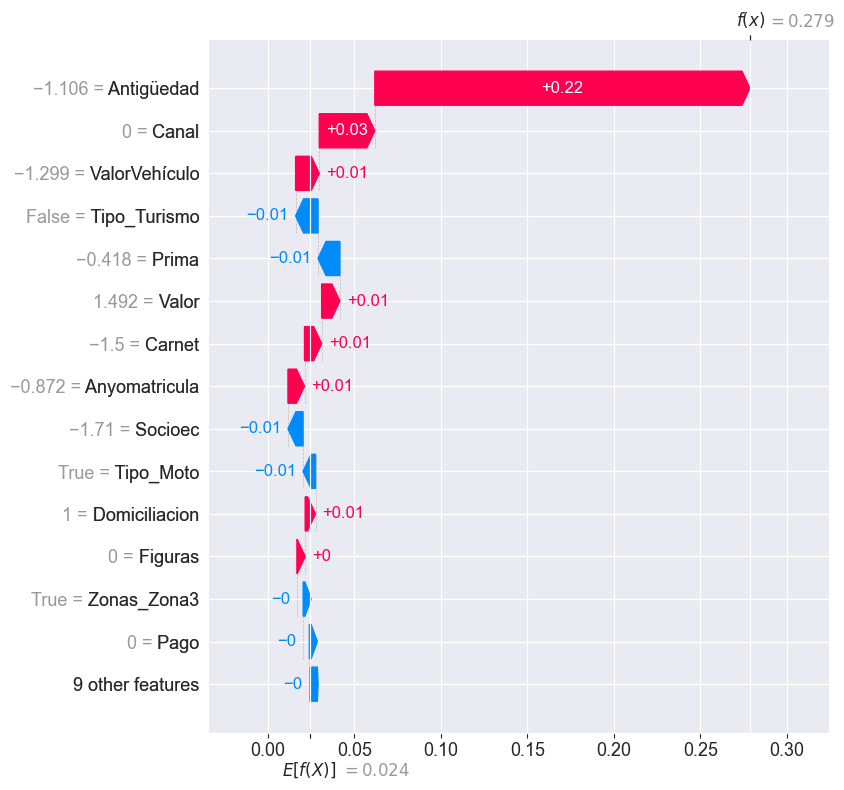

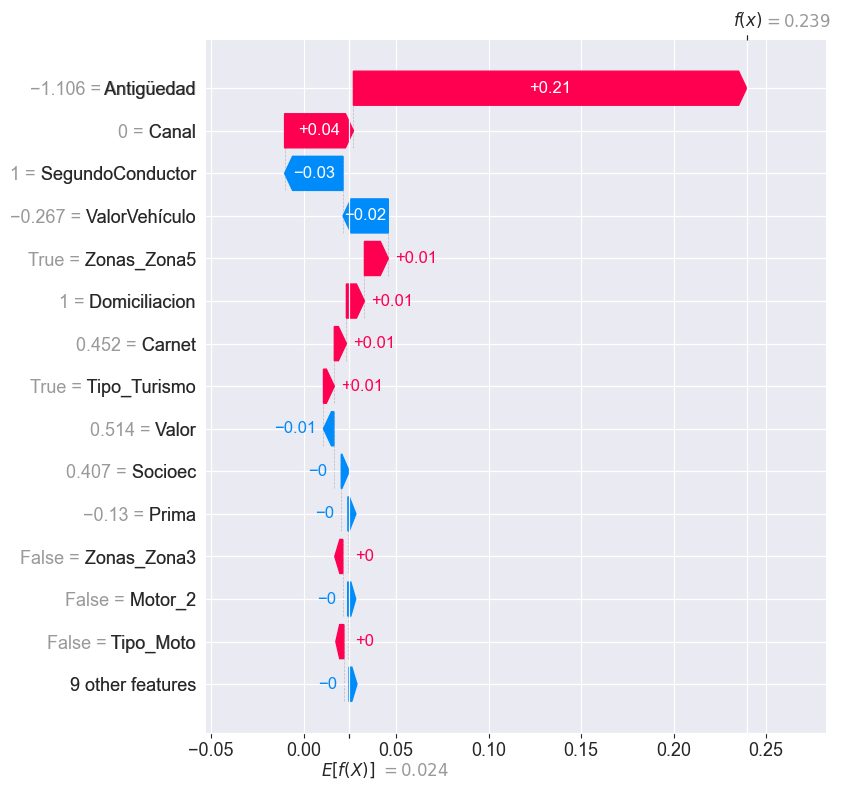

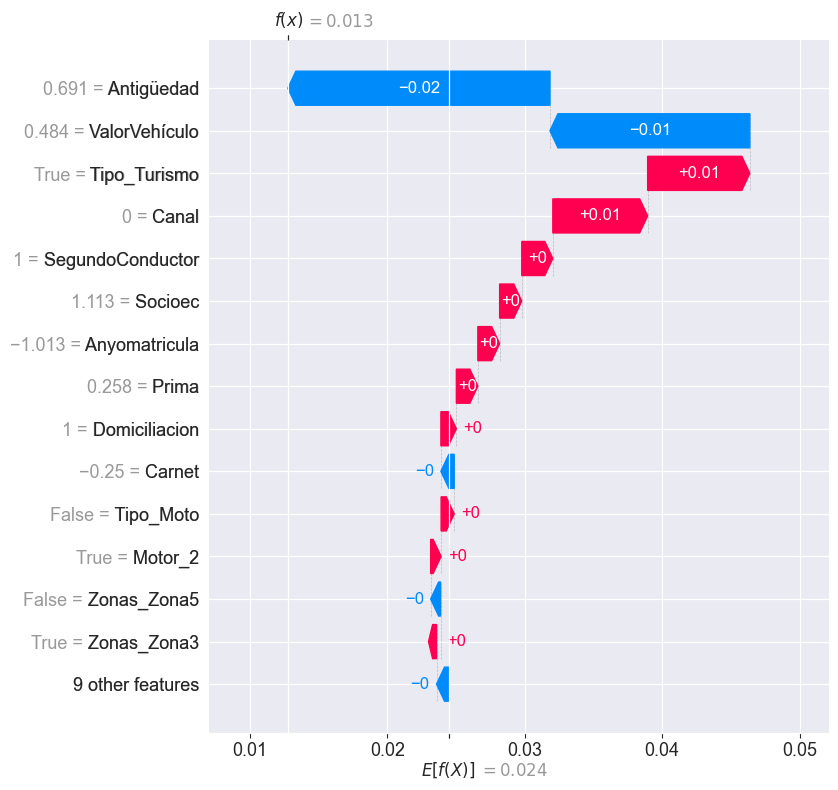

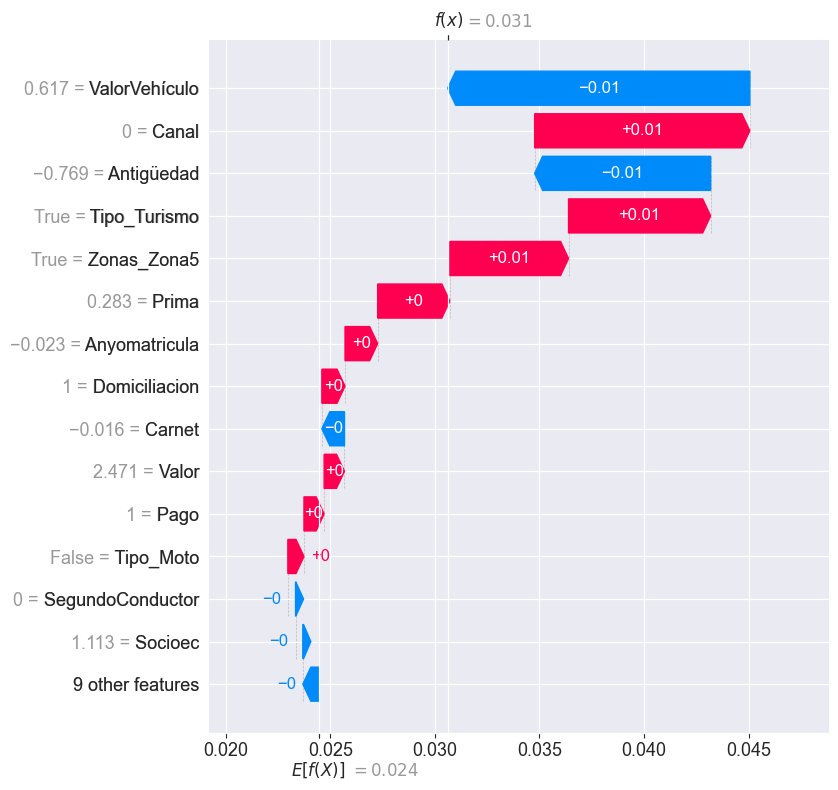

In [27]:

idx_show = np.r_[fp[:2], fn[:2]]
X_local = X_test.iloc[idx_show]

sv_local = explainer(X_local)

sv_local_pos = sv_local[..., 1]

for i in range(len(idx_show)):
    shap.plots.waterfall(sv_local_pos[i], max_display=15)


In [ ]:
thr = 0.154641

sv_e = explainer(X_test)
sv_pos = sv_e[:, :, 1]
S = pd.DataFrame(sv_pos.values, columns=X_test.columns, index=X_test.index)




In [31]:
proba_e = rf.predict_proba(X_test)[:, 1]
y_pred_e = (proba_e >= thr).astype(int)
y_true_e = y_test.loc[X_test.index].to_numpy()  # mantiene alineación por índice

fp_mask = (y_true_e == 0) & (y_pred_e == 1)
fn_mask = (y_true_e == 1) & (y_pred_e == 0)

top_fp = S.loc[fp_mask].abs().mean().sort_values(ascending=False).head(15)
top_fn = S.loc[fn_mask].abs().mean().sort_values(ascending=False).head(15)

top_fp, top_fn

(Antigüedad          0.199744
 ValorVehículo       0.047931
 Canal               0.029633
 Tipo_Turismo        0.019214
 Prima               0.011129
 Domiciliacion       0.010972
 Carnet              0.009320
 Anyomatricula       0.008474
 Socioec             0.007040
 Valor               0.005782
 Tipo_Moto           0.003984
 SegundoConductor    0.003695
 Motor_2             0.003589
 Zonas_Zona2         0.003394
 Pago                0.003003
 dtype: float64,
 Antigüedad       0.034630
 ValorVehículo    0.025784
 Canal            0.014030
 Tipo_Turismo     0.013055
 Prima            0.004955
 Anyomatricula    0.004528
 Carnet           0.002887
 Domiciliacion    0.002762
 Socioec          0.002517
 Valor            0.002439
 Tipo_Moto        0.002286
 Zonas_Zona5      0.002273
 Motor_2          0.001606
 Pago             0.001102
 Zonas_Zona2      0.000788
 dtype: float64)

In [5]:
from xgboost import XGBClassifier
import xgboost

xgb_params = {
    "colsample_bytree": 0.7,
    "subsample": 0.8,
    "gamma": 1.0,
    "max_depth": 5,
    "min_child_weight": 12,
    "reg_alpha": 2,
    "reg_lambda": 3.0,
    "learning_rate": 0.03,
    "n_estimators": 2000,
    "scale_pos_weight": 1
}

X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42
    )

early_stop = xgboost.callback.EarlyStopping(
        rounds=150,
        metric_name="aucpr",
        data_name="validation_0",
        save_best=True,
        maximize=True
    )

xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        callbacks=[early_stop],
        **xgb_params
    )

xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# rf, aucs, fp, fn, ex  = run_model_and_evaluate_xgb(
#                 X_train, y_train,
#                 X_test, y_test, xgb_params
#             )



,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,[<xgboost.call...001AF1CDC3110>]
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


Vamos a implementar la explicabilidad para XGBoost

 98%|===================| 5749/5845 [00:57<00:00]        

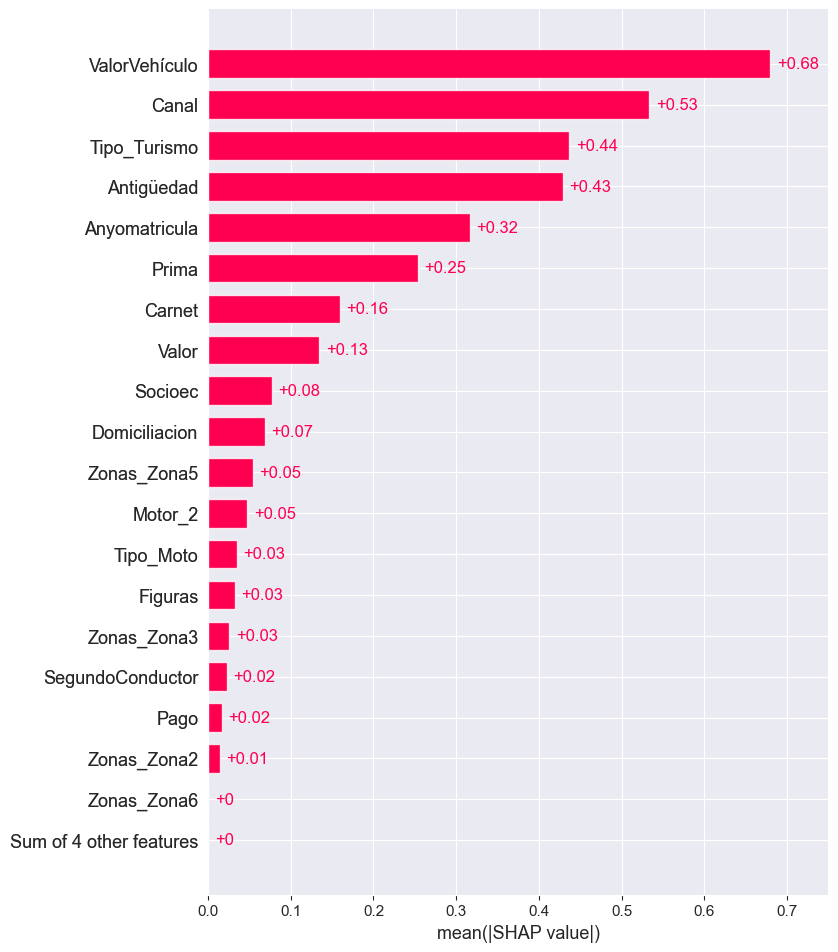

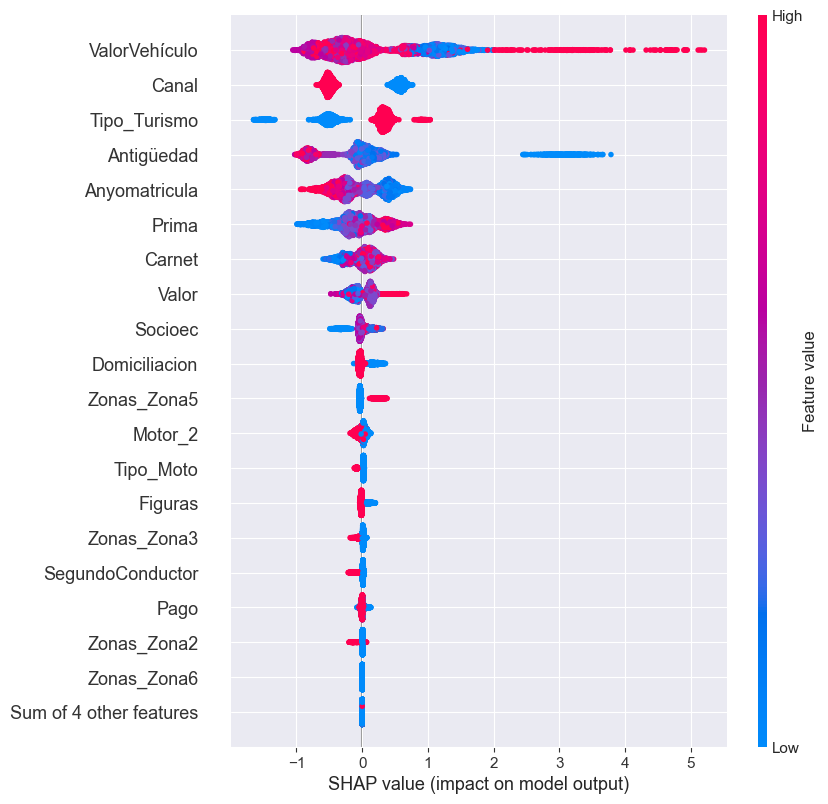

In [11]:

import shap

X_tr_num   = X_tr.astype("float32")
X_test_num = X_test.astype("float32")
# model = XGBClassifier(...) ya entrenado
explainer = shap.Explainer(xgb, X_tr_num)      # usa TreeExplainer internamente
sv = explainer(X_test)                          # shap.Explanation

# Global: importancia
shap.plots.bar(sv, max_display=20)

# Global: beeswarm (dirección + dispersión)
shap.plots.beeswarm(sv, max_display=20)


In [ ]:
shap.plots.scatter(sv[:, "ValorVehículo"])
shap.plots.scatter(sv[:, "Antigüedad"])
shap.plots.scatter(sv[:, "Canal"])
